In [1]:
import sys, glob
import numpy as np
import logging
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.dataset as dataset
import snelib19odp.lc.observables as observables
import snelib19odp.dataset as dataset
#import snelib19odp.mftools.sim as sim
import snelib19odp.utils as utils
import astropy.table as table

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
#logging.basicConfig(level=logging.DEBUG)
import seaborn
import astropy.time as time

import corner, os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from tqdm import tqdm_notebook
from collections import OrderedDict
from mosfit.plotting import bandcolorf

sns.reset_orig()

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 14})

#products_dir = '../products/mosfit_runs/19odp_allbands/1636128430'
#products_dir = '../products/mosfit_runs/13bvn/1636301260'
#products_dir = '../products/mosfit_runs/13bvn/1636322060'
#products_dir = '../products/mosfit_runs/08d/1636327993'
#products_dir = '../products/mosfit_runs/08d/1636453171'
#products_dir = '../products/mosfit_runs/08d_ib/1636497232'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636380058'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636415336'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636445332'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636449254'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636458300'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636459134'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636461456'
#products_dir = '../products/mosfit_runs/19odp_allbands/1636463588'
#products_dir = '../products/mosfit_runs/19odp_allbands_red_only/1636464699'
#products_dir = '../products/mosfit_runs/19odp_allbands_fit_host_nh/1636465791'
#products_dir = '../products/mosfit_runs/19odp_allbands_ic/1636471046'
#products_dir = '../products/mosfit_runs/19odp_allbands_slsn/1636472874'
#products_dir = '../products/mosfit_runs/19odp_allbands_ib/1636475283'
#products_dir = '../products/mosfit_runs/19odp_allbands_ib/1636487337'
#products_dir = '../products/mosfit_runs/13bvn/1636452119'
#products_dir = '../products/mosfit_runs/13bvn_ib/1636493205'
#products_dir = '../products/mosfit_runs/98bw/1636535588'

ds_name = 'SN2019odp_phot'
#ds_name = 'SN2008D'
#ds_name = 'iPTF13bvn'
#ds_name = 'SN1998bw'
model_name = '19odp_short'
products_dir = sorted(glob.glob('../products/mosfit_runs/%s/*' % model_name))[-1]
run_id = int(products_dir.split('/')[-1])
print('Model Name: ', model_name)
print('Dataset   : ', ds_name)
print('ProductDir: ', products_dir)
print('Run ID    : ', run_id)

Model Name:  19odp_short
Dataset   :  SN2019odp_phot
ProductDir:  ../products/mosfit_runs/19odp_short/1636133208
Run ID    :  1636133208


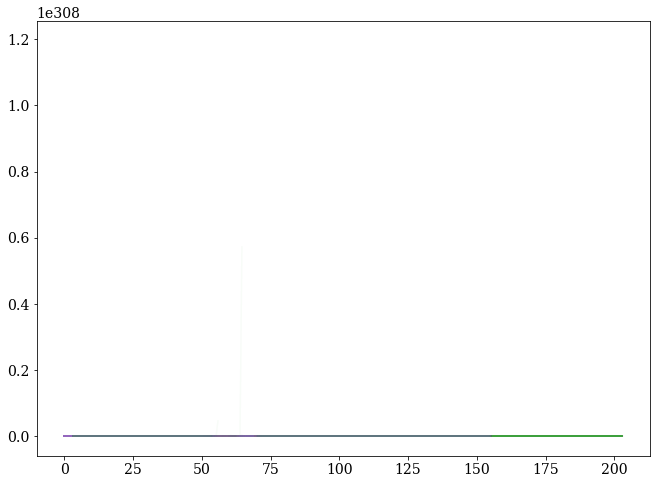

In [2]:
plt.figure(figsize=(11,8))
with open(os.path.join(products_dir, 'mosfit/products/extras.json'), 'r', encoding = 'utf-8') as f:
    extra = json.loads(f.read())

dense_times = extra['dense_times']
dense_lums = extra['dense_luminosities']

ds = dataset.load_dataset(ds_name)

t_min = ds.first_detection_mjd

for t,l in zip(dense_times, dense_lums):
    plt.plot(t-np.min(t), l, alpha=0.05, color='tab:purple')
    t_grid = np.linspace(t_min, t_min+200, 300)
    lc = ds.sample_abs_lc(method='lyman', t_grid=t_grid)
    lums = utils.convert_luminosity(lc)
    plt.plot(t_grid - t_min + 3, lums, alpha=0.03, color='tab:green')

In [3]:
with open(os.path.join(products_dir, 'mosfit/products/walkers.json'), 'r', encoding = 'utf-8') as f:
    data = json.loads(f.read())
    if 'name' not in data:
        data = data[list(data.keys())[0]]

photo = data['photometry']
model = data['models'][0]

real_data = len([x for x in photo if 'band' in x and 'magnitude' in x and (
    'realization' not in x or 'simulated' in x)]) > 0

band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
band_list = list(set([tuple(x.get(y, '')
                            for y in band_attr) for x in photo
                            if 'band' in x and 'magnitude' in x]))
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
xray_instrument_attr = ['instrument', 'telescope']
xray_instrument_list = list(set([tuple(x.get(y, '')
                            for y in xray_instrument_attr) for x in photo
                            if 'instrument' in x and 'countrate' in x])) 
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
real_xray_instrument_list = list(set([tuple(x.get(y, '')
                                 for y in xray_instrument_attr) for x in photo
                                 if 'instrument' in x and 'countrate' in x and (
                                     'realization' not in x or 'simulated' in x)]))

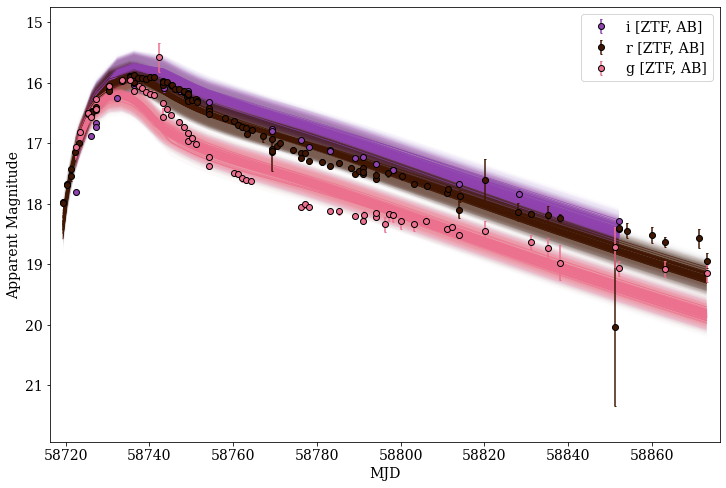

In [4]:
fig = plt.figure(figsize=(12,8))
plt.gca().invert_yaxis()
plt.gca().set_xlabel('MJD')
plt.gca().set_ylabel('Apparent Magnitude')
used_bands = []

#lc = ds.get_combined_lc('g')
#plt.scatter(lc['mjd'], lc['mag'], label='Corrected & Combined', marker='o')

for full_band in band_list:#, desc='Photo', leave=False):
    (band, inst, tele, syst, bset) = full_band
    try:
        inst_exclusive_list
    except:
        pass
    else:
        if inst not in inst_exclusive_list:
            continue
    #if band != 'i':
    #    continue
    extra_nice = ', '.join(list(filter(None, OrderedDict.fromkeys((inst, syst, bset)).keys())))
    nice_name = band + ((' [' + extra_nice + ']') if extra_nice else '')
    
    realizations = [[] for x in range(len(model['realizations']))]
    for ph in photo:
        rn = ph.get('realization', None)
        si = ph.get('simulated', False)
        if rn and not si:
            if tuple(ph.get(y, '') for y in band_attr) == full_band:
                realizations[int(rn) - 1].append((
                    float(ph['time']), float(ph['magnitude']), [
                        float(ph.get('e_lower_magnitude', ph.get('e_magnitude', 0.0))),
                        float(ph.get('e_upper_magnitude', ph.get('e_magnitude', 0.0)))],
                ph.get('upperlimit')))
    numrz = np.sum([1 for x in realizations if len(x)])
    for rz in realizations:
        if not len(rz):
            continue
        xs, ys, vs, us = zip(*rz)
        label = '' if full_band in used_bands or full_band in real_band_list else nice_name
        if max(vs) == 0.0:
            plt.plot(xs, ys, color=bandcolorf(band),
                             label=label, linewidth=0.5)
        else:
            xs = np.array(xs)
            ymi = np.array(ys) - np.array([np.inf if u else v[0] for v, u in zip(vs, us)])
            yma = np.array(ys) + np.array([v[1] for v in vs])
            plt.fill_between(xs, ymi, yma, color=bandcolorf(band), edgecolor=None,
                             label=label, alpha=1.0/numrz, linewidth=0.0)
            plt.plot(xs, ys, color=bandcolorf(band), 
                             label=label, alpha=1.0, linewidth=0.5)
        if label:
            used_bands = list(set(used_bands + [full_band]))
    if real_data:
        for s in range(2):
            if s == 0:
                cond = False
                symb = 'o'
            else:
                cond = True
                symb = 'v'
            vec = [(float(x['time']), float(x['magnitude']),
                    0.0 if 'upperlimit' in x else float(x.get('e_lower_magnitude', x.get('e_magnitude', 0.0))),
                    float(x.get('e_upper_magnitude', x.get('e_magnitude', 0.0)))) for x in photo
                   if 'magnitude' in x and ('realization' not in x or 'simulated' in x) and
                   'host' not in x and 'includeshost' not in x and
                   x.get('upperlimit', False) == cond and
                   tuple(x.get(y, '') for y in band_attr) == full_band]
            if not len(vec):
                continue
            xs, ys, yls, yus = zip(*vec)
            label = nice_name if full_band not in used_bands else ''
            plt.errorbar(xs, ys, yerr=(yus, yls), color=bandcolorf(band), fmt=symb,
                         label=label,
                         markeredgecolor='black', markeredgewidth=1, capsize=1,
                         elinewidth=1.5, capthick=2, zorder=10)
            #plt.errorbar(xs, ys, yerr=(yus, yls), color='k', fmt=symb, capsize=2,
            #             elinewidth=2.5, capthick=3, zorder=5)
            if label:
                used_bands = list(set(used_bands + [full_band]))
plt.margins(0.02, 0.1)
#plt.ylim((22, 15))
#plt.xlim((58719, 58800))
plt.legend()
#plt.show()
plt.savefig('../paper/plots/tmp_mosfit/%s_%d_lc.png' % (model_name, run_id))

In [5]:
# Construct walker arrays for corner
corner_input = []
pars = [x for x in model['setup'] if model['setup'][x].get('kind') == 'parameter' and
        'min_value' in model['setup'][x] and 'max_value' in model['setup'][x]]
weights = []
for realization in model['realizations']:
    par_vals = realization['parameters']
    if 'weight' in realization:
        weights.append(float(realization['weight']))
    var_names = ['$' + ('\\log\\, ' if par_vals[x].get('log') else '') +
                 par_vals[x]['latex'] + '$' for x in par_vals if x in pars and 'fraction' in par_vals[x]]
    corner_input.append([np.log(par_vals[x]['value']) if
                         par_vals[x].get('log') else par_vals[x]['value'] for x in par_vals
                         if x in pars and 'fraction' in par_vals[x]])
weights = weights if len(weights) else None
ranges = [0.999 for x in range(len(corner_input[0]))]
cfig = corner.corner(np.array(corner_input), labels=var_names, quantiles=[0.16, 0.5, 0.84],
                     show_titles=True, weights=weights, range=ranges)
plt.savefig('../paper/plots/tmp_mosfit/%s_%d_corner.png' % (model_name, run_id))

In [6]:
np.array(corner_input).shape

(2121, 8)

In [7]:
realization['parameters']

{'avhost': {'value': 0.00018201935649017574},
 'codeltalambda': {'latex': 'l_\\lambda', 'log': True, 'value': -1.0},
 'codeltatime': {'latex': 'l_t', 'log': True, 'value': -1.0},
 'default_no_error_bar_error': {'latex': 'default_no_error_bar_error',
  'log': False,
  'value': 0.0},
 'default_upper_limit_error': {'latex': 'default_upper_limit_error',
  'log': False,
  'value': 0.1},
 'ebv': {'latex': 'E({\\rm B} - {\\rm V})', 'log': False, 'value': 0.0},
 'fnickel': {'fraction': 0.7855998613950728,
  'latex': 'f_{\\rm Ni}',
  'log': True,
  'value': 0.22740477736102738},
 'kappa': {'latex': '\\kappa\\,({\\rm cm}^{2}\\,{\\rm g}^{-1})',
  'log': False,
  'value': 0.2},
 'kappagamma': {'fraction': 0.0427842503039462,
  'latex': '\\kappa_\\gamma\\,({\\rm cm}^{2}\\,{\\rm g}^{-1})',
  'log': True,
  'value': 0.16365197524530553},
 'lumdist': {'latex': 'd_{L}', 'log': True, 'value': 64.0},
 'mejecta': {'fraction': 0.6085776835238788,
  'latex': 'M_{\\rm ej}\\,(M_\\odot)',
  'log': True,
  'val

In [8]:
t = {}
PARAMS = ['fnickel', 'vejecta', 'mejecta', 'kappa']
for p in PARAMS:
    t[p] = np.empty(len(model['realizations']))

for i,realization in enumerate(model['realizations']):
    #print(realization)
    for p in PARAMS:
        t[p][i] = realization['parameters'][p]['value']
t = table.Table(t)
t

<Table length=2121>
      fnickel            vejecta            mejecta        kappa 
      float64            float64            float64       float64
------------------- ------------------ ------------------ -------
0.27750791997503865 12340.709163607142 0.8206076635787151     0.2
 0.2230713511055658 12922.558801210893  1.086242092086652     0.2
 0.1996378646458896 12152.984770896848 1.1021094134059988     0.2
0.20803799954583926 12792.628752566001 1.1504306491956073     0.2
0.21800264491274834 12724.891256534134 1.3432403052070183     0.2
0.24626108044227293  12709.36844045822   0.90584925752965     0.2
 0.3146803488397931 12065.557840212728  0.798608522595873     0.2
0.17188753170958623  12243.36264872521 1.3027009561128016     0.2
0.20044821811773456  12614.31870872883 1.3576802613371988     0.2
0.16133897272134196 12586.220451756519  1.427098903534083     0.2
                ...                ...                ...     ...
0.20265953713394028 12004.984619089748 1.2812453983605125     0.2
0.22290593878292678 12096.181587592557 1.0913829985310133     0.2
0.23091967890306211 12107.989941790884 1.0798481457544071     0.2
0.22052488791563668 12143.685305120858 1.0936859859969152     0.2
0.22594952141278962  12358.43143231723 1.1308265422386303     0.2
0.21528620284391595 12053.508631555542 1.1744925637454255     0.2
0.24304123695601515 12503.043287931401 1.0112198486197044     0.2
0.22015306179704244 12071.637008290392 1.1863049022183112     0.2
 0.2678615557092366  12051.98815046138 0.8765212428072399     0.2
0.22740477736102738 12121.763082510903 1.1037949877099489     0.2

In [9]:
import seaborn
seaborn.kdeplot(t['mejecta'], t['vejecta'])
plt.savefig('../paper/plots/tmp_mosfit/%s_%d_mej_vej.png' % (model_name, run_id))

Text(0.5, 0, 'Mnickel')

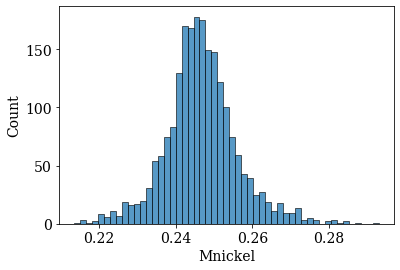

In [10]:
seaborn.histplot(t['mejecta']*t['fnickel'])
plt.xlabel('Mnickel')

In [11]:
np.percentile(t['mejecta']*t['fnickel'], [15.9, 50, 68.2])

array([0.23880375, 0.2462666 , 0.24997485])

In [12]:
0.21216518 - 0.21612951

-0.003964329999999988

In [13]:
0.21757184 - 0.21612951

0.0014423299999999917

In [14]:
pars

['codeltalambda',
 'codeltatime',
 'fnickel',
 'kappagamma',
 'lumdist',
 'mejecta',
 'nhhost',
 'redshift',
 'temperature',
 'texplosion',
 'variance',
 'vejecta']

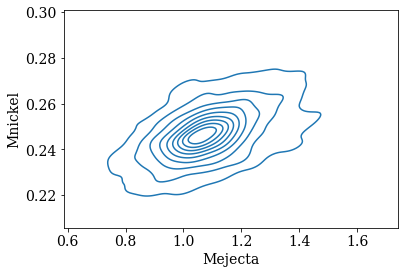

In [15]:
seaborn.kdeplot(t['mejecta'], t['mejecta']*t['fnickel'])
plt.xlabel('Mejecta')
plt.ylabel('Mnickel')
plt.savefig('../paper/plots/tmp_mosfit/%s_%d_mej_mni.png' % (model_name, run_id))